In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, quantile_transform
from umap import UMAP
from matplotlib import pyplot as plt

from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from one.api import ONE

import sys
sys.path.append('/home/crombie/code/ibl_photometry/src')
import iblphotometry.processing as proc
import iblphotometry.pipelines as pipelines
import iblphotometry.metrics as metrics

from iblnm.io import load_photometry_data
from iblnm.util import _agg_sliding_metric, restrict_photometry_to_task, _load_event_times
from iblnm.vis import *

#### List which metrics that we are interested in

In [2]:
csv_metrics = [
    'n_early_samples',
    'n_repeated_samples'
]

raw_metrics = [
    'n_unique_samples',
    'f_unique_samples',
    # 'bleaching_tau',
    # 'bleaching_amp',
]

sliding_metrics = [
    'deviance',
    # 'n_spikes_dy',
    'n_expmax_violations',
    'expmax_violation',
    'percentile_dist',
    'signal_asymmetry',
]

processed_metrics = [
    'low_freq_power_ratio',
    'ar_score'
]

# Run the QC loop

In [2]:
# %run -i qc_photometry.py

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:183: UserWarning: Large cache tables affect performance. Consider removing them by calling the `_remove_table_files` method.
  warnings.warn(


# Evaluate QC outcomes

#### Load the file generated by the qc_photometry.py script

In [3]:
qc_fname = 'qc_photometry.pqt'
df_qc = pd.read_parquet(qc_fname)
# Add a combined target-NM column
df_qc['target_NM'] = df_qc.apply(lambda x: '-'.join([x['target'], x['NM']]), axis='columns')

#### Plot distributions for all metrics

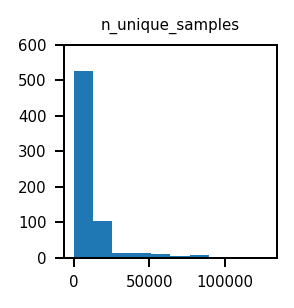

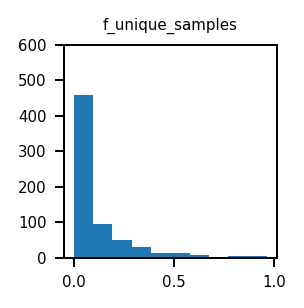

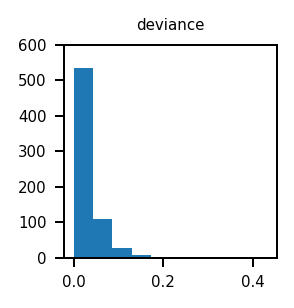

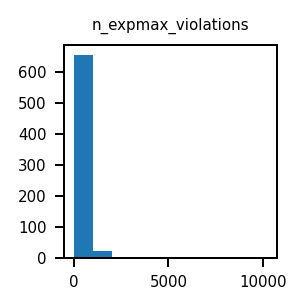

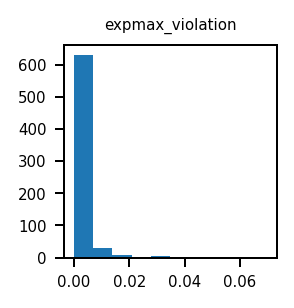

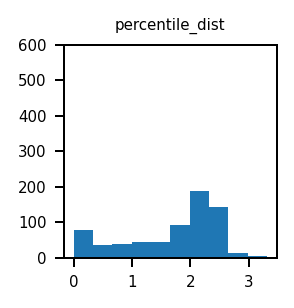

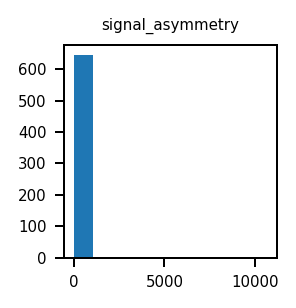

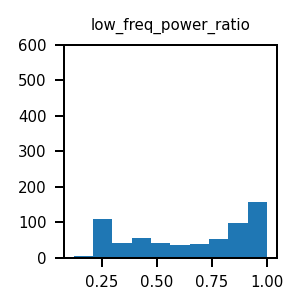

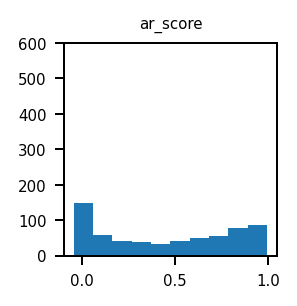

In [4]:
%matplotlib inline

for metric in raw_metrics + sliding_metrics + processed_metrics:
    fig, ax = plt.subplots()
    metric_values = df_qc[metric].replace({np.inf:np.nan})
    ax.set_title(metric)
    ax.hist(metric_values.dropna())
    ax.set_yticks(np.arange(0, len(metric_values) // 100 + 1) * 100)
    set_plotsize(w=3, ax=ax)

#### Based on the distributions, decid which metrics should be log-transformed

In [5]:
metric_logtransform = {
    'deviance': True,
    'n_expmax_violations': True,
    'expmax_violation': True,
    'percentile_dist': False,
    'signal_asymmetry': True,
    'low_freq_power_ratio': False,
    'ar_score': False
}

#### Replace overall metric value with mean of values computes in sliding windows

In [6]:
slidingmetric_aggfunc = {
    'deviance': np.mean,
    'percentile_dist': np.mean,
    'signal_asymmetry': np.mean,
    'n_expmax_violations': np.sum,
    'expmax_violation': np.mean
}

for metric, agg_func in slidingmetric_aggfunc.items():
    df_qc[metric] = df_qc.apply(_agg_sliding_metric, metric=metric, agg_func=agg_func, axis='columns')

#### Plot metric distributions for each target-NM, separate old and new recordings

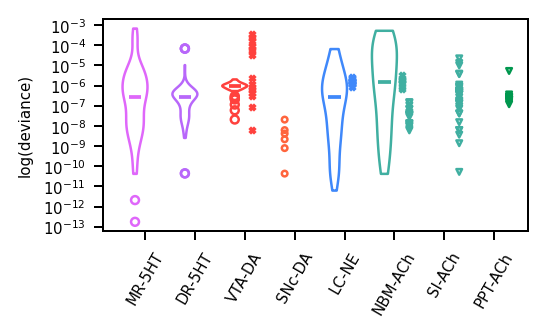

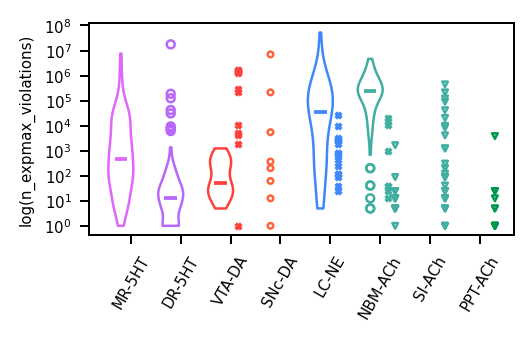

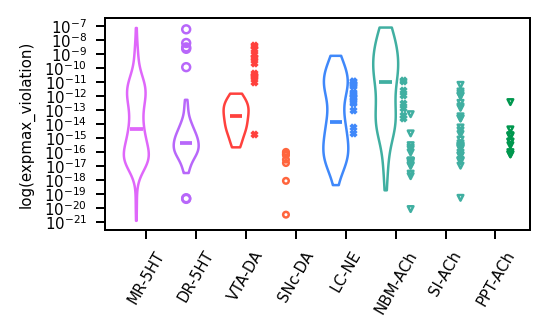

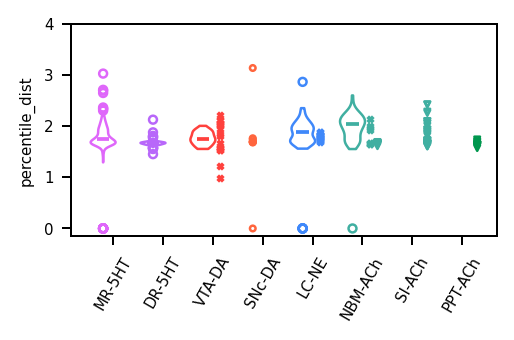

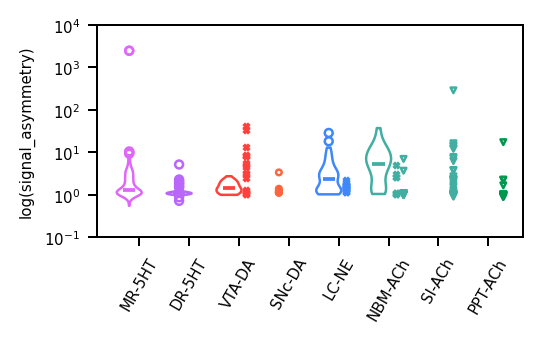

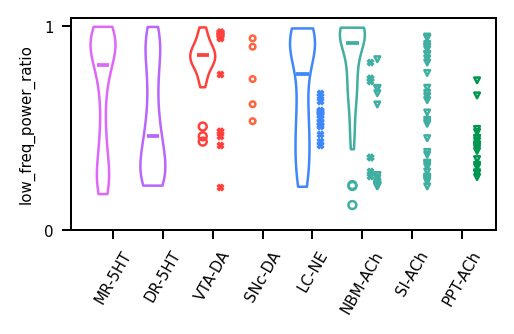

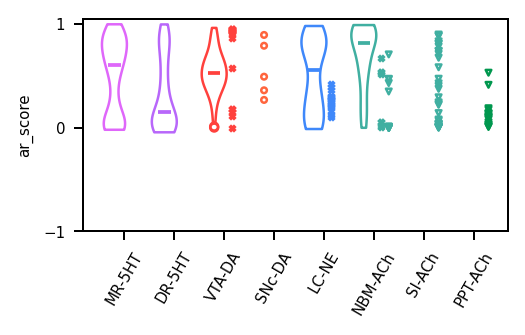

In [7]:
%matplotlib inline

new_recordings = df_qc['start_time'].apply(lambda x: datetime.fromisoformat(x) >  datetime(2024, 4, 1))
targetNMs_old = df_qc[~new_recordings].groupby('target_NM')
targetNMs_new = df_qc[new_recordings].groupby('target_NM')

for metric in sliding_metrics + processed_metrics:
    fig, ax = plt.subplots()
    data = [tnm[metric].replace({np.inf:np.nan}).dropna() for _, tnm in targetNMs_old]
    if metric_logtransform[metric]:
        data = [np.log(x[x > 0]) for x in data]
    else:
        data = [np.array(x) for x in data]
    xpos = np.array(list(TARGETNM_POSITIONS.values())) - 0.2
    violins = violinplot(ax, data, positions=xpos, colors=TARGETNM_COLORS.values())
    xpos = np.array(list(TARGETNM_POSITIONS.values()))
    for tnm, group in targetNMs_new:
        group = group.dropna(subset=metric)
        new_data = group[metric].values
        mainenlab = np.array(['ZFM' in s for s in group['subject']])
        if metric_logtransform[metric]:
            mainenlab = mainenlab[new_data > 0]
            new_data = np.log(new_data[new_data > 0])
        xx = np.ones_like(new_data) * (TARGETNM_POSITIONS[tnm] + 0.2)
        ax.scatter(xx[mainenlab] - 0.05, new_data[mainenlab], s=5, color=TARGETNM_COLORS[tnm], marker='x')
        ax.scatter(xx[~mainenlab] + 0.1, new_data[~mainenlab], s=5, fc='none', ec=TARGETNM_COLORS[tnm], marker='v')
    ax.set_xticks(list(TARGETNM_POSITIONS.values()))
    ax.set_xticklabels(TARGETNM_POSITIONS.keys())
    ax.tick_params(axis='x', rotation=60)
    
    h = np.ceil(max(np.concatenate(data).max(), new_data.max()))
    l = np.floor(min(np.concatenate(data).min(), new_data.min()))
    yticks = np.arange(l, h + 1, 1)
    ax.set_yticks(yticks)
    if metric_logtransform[metric]:
        ax.set_ylabel(f'log({metric})')
        ax.set_yticklabels(['$10^{%d}$' % t for t in yticks])
    else:
        ax.set_ylabel(metric)

    set_plotsize(w=6, h=3, ax=ax)

## Target-NM decoding

#### Pair-wise metric distribution scatter plots

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwa

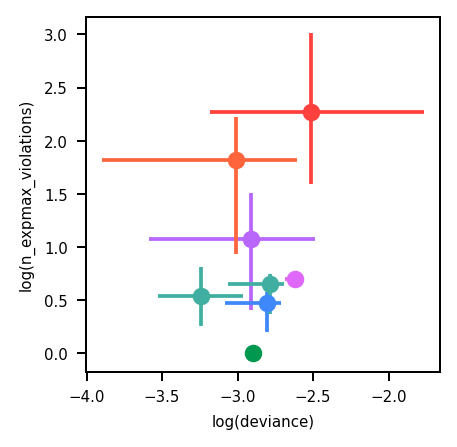

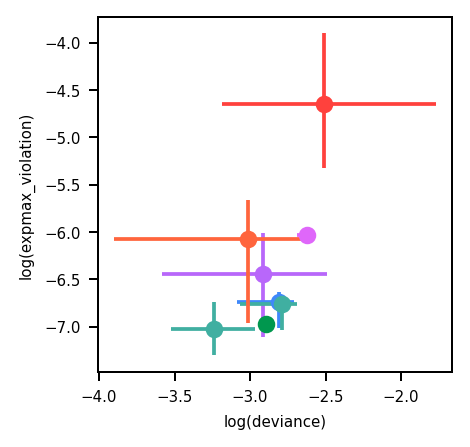

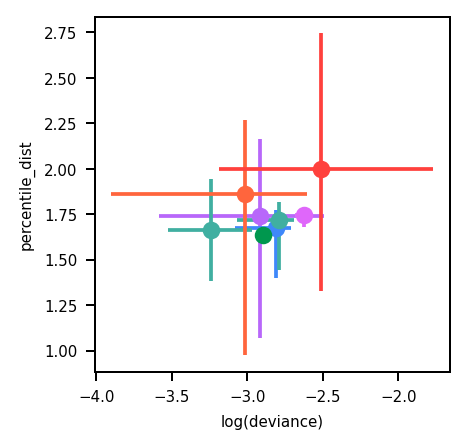

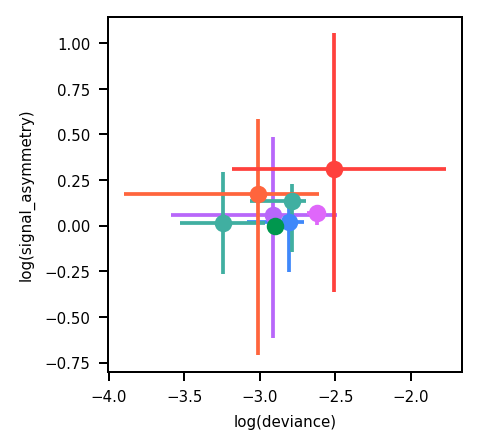

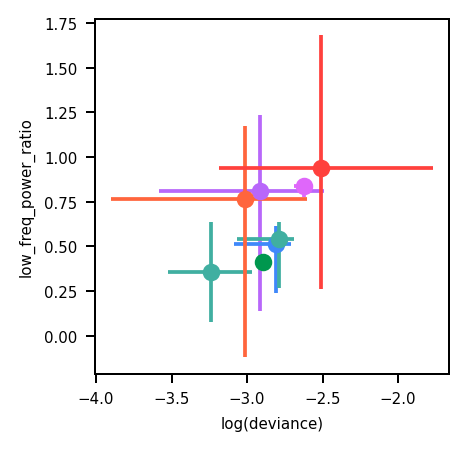

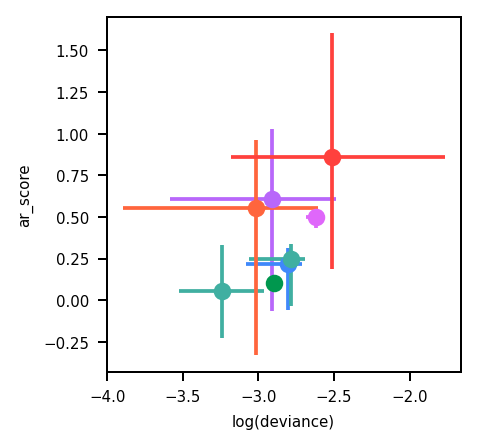

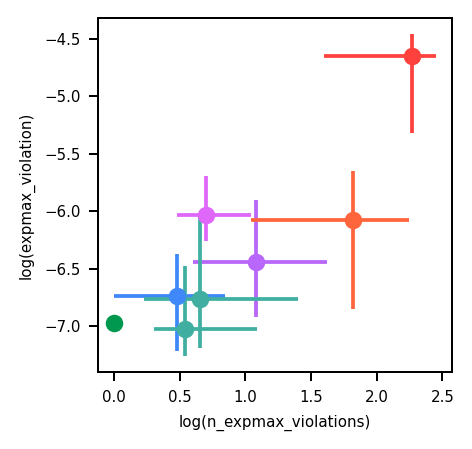

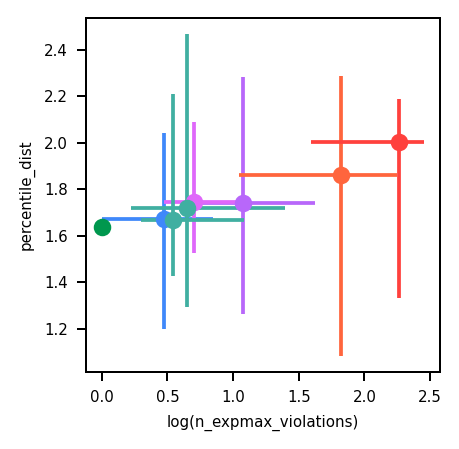

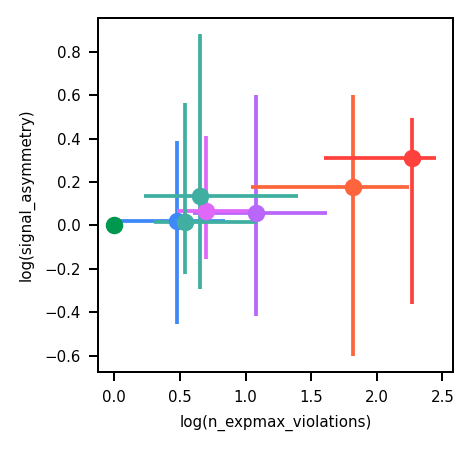

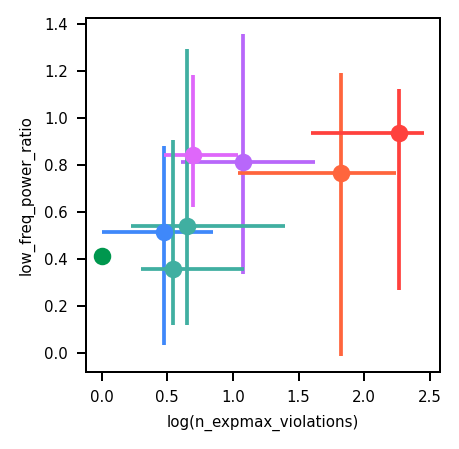

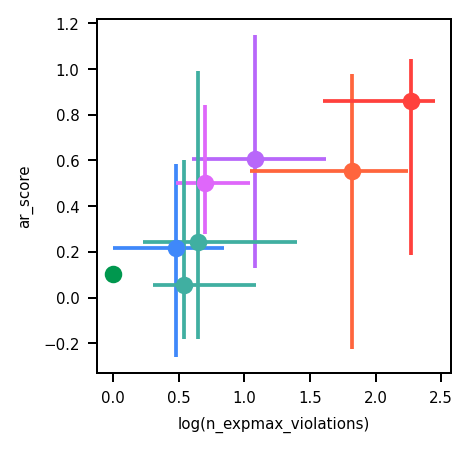

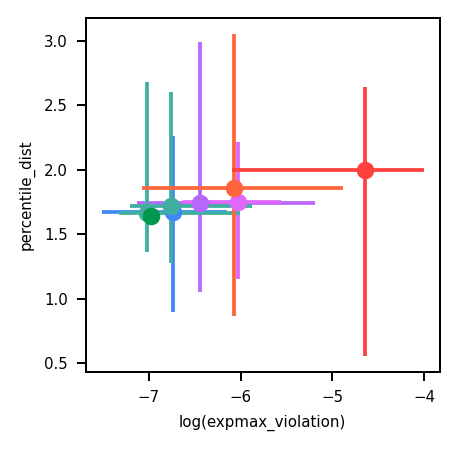

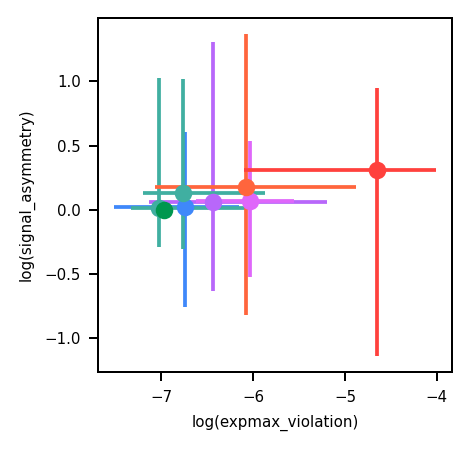

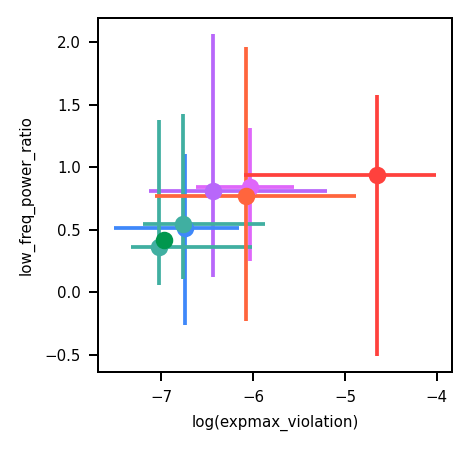

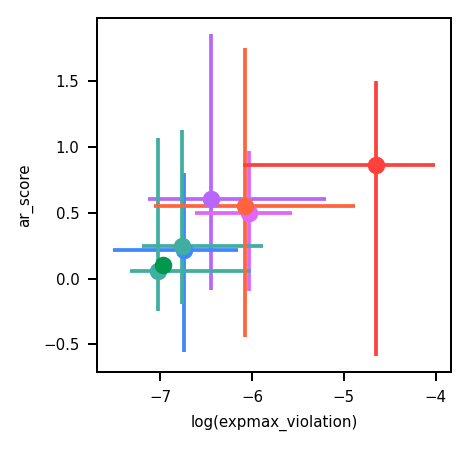

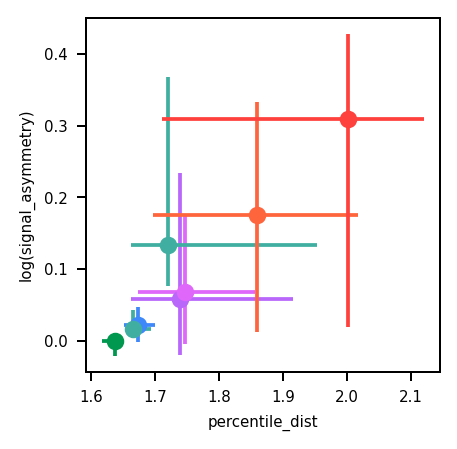

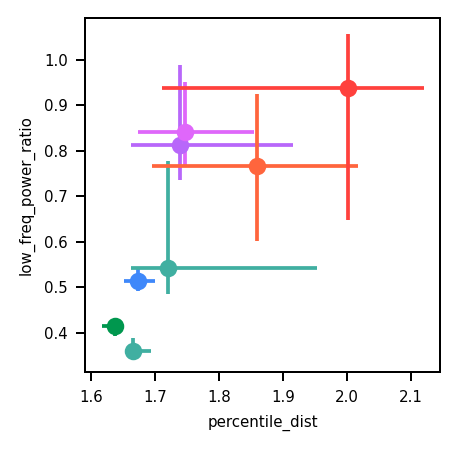

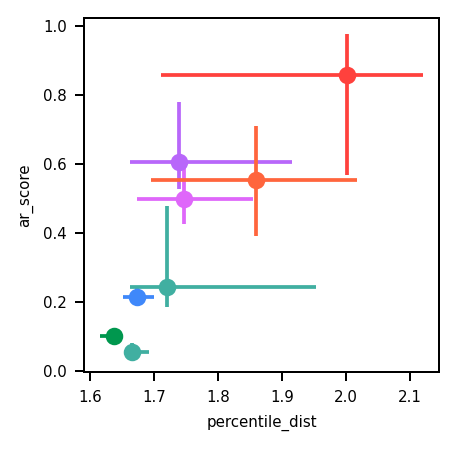

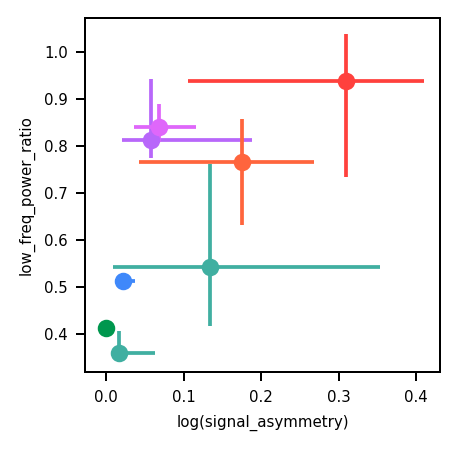

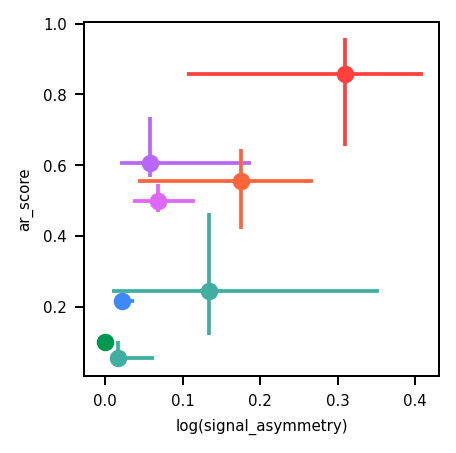

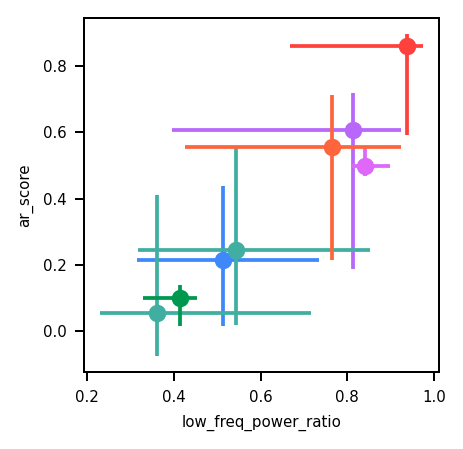

In [8]:
m = sliding_metrics + processed_metrics
for i in range(len(m)):
    for j in range(len(m)):
        if i >= j:
            continue

        fig, ax = plt.subplots()
        for target_NM, group in df_qc.groupby('target_NM'):
            
            mi_values = np.log10(group[m[i]]) if metric_logtransform[m[i]] else group[m[i]]
            x_neg, x, x_pos = mi_values.dropna().quantile([.25, .5, .75])
            x_neg = x - x_neg
            x_pos = x_pos - x
            
            mj_values = np.log10(group[m[j]]) if metric_logtransform[m[j]] else group[m[j]]
            y_neg, y, y_pos = mj_values.dropna().quantile([.25, .5, .75])
            y_neg = y - y_neg
            y_pos = y_pos - y
            
            ax.errorbar(
                x, y, xerr=np.array([[x_neg], [x_pos]]), yerr=np.array([[x_neg], [x_pos]]), 
                marker='o', color=TARGETNM_COLORS[target_NM]
            )
            if metric_logtransform[m[i]]:
                ax.set_xlabel(f'log({m[i]})')
            else:
                ax.set_xlabel(m[i])
            if metric_logtransform[m[j]]:
                ax.set_ylabel(f'log({m[j]})')
            else:
                ax.set_ylabel(m[j])
        
        set_plotsize(w=5, ax=ax)

In [9]:
for metric in sliding_metrics + processed_metrics:
    df_qc[f'log_{metric}'] = np.log10(df_qc[metric]).replace({np.inf:np.nan, -np.inf:np.nan})

comp_metrics = [
    'log_deviance',
    'log_n_expmax_violations',
    'log_expmax_violation',
    'percentile_dist',
    'log_signal_asymmetry',
    'low_freq_power_ratio',
    'ar_score'
]

qc_mask =  df_qc['n_unique_samples'] > 100
nan_mask = df_qc[comp_metrics].notna().all(axis=1)
X = df_qc[comp_metrics][qc_mask & nan_mask].values
y = df_qc['target_NM'][qc_mask & nan_mask].values

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwar

In [10]:
# Train logistic regression with OvO
classifier = OneVsOneClassifier(
    LogisticRegression(class_weight='balanced', solver='liblinear')
)
classifier.fit(X, y)
y_pred = classifier.predict(X)
score = classifier.score(X, y)
print(score)

0.31098696461824954


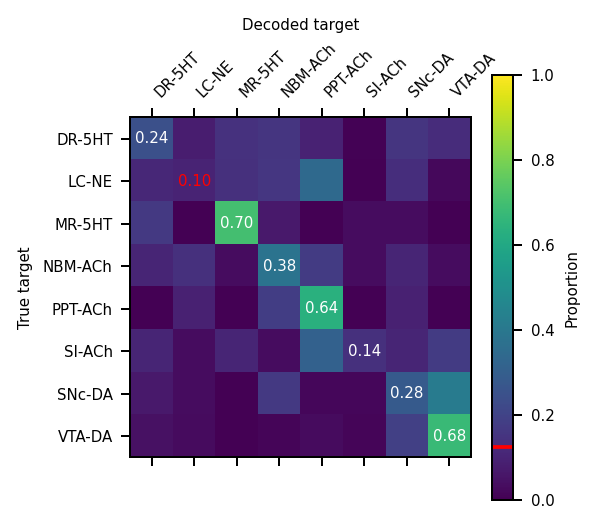

In [11]:
# Confusion matrix
cm = confusion_matrix(y, y_pred, labels=classifier.classes_, normalize='true')
labels = classifier.classes_

fig, ax = plt.subplots()
mat = ax.matshow(cm, vmin=0, vmax=1)
cbar = plt.colorbar(mat, ax=ax)
cbar.set_label('Proportion')
chance = 1 / len(cm)
cbar.ax.axhline(chance, color='red')

# Annotate diagonal cells with proportion values
for i in range(len(labels)):
    value = cm[i, i]
    ax.text(i, i, f"{value:.2f}", va='center', ha='center', color='white' if value > chance else 'red', fontsize=LABELFONTSIZE)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='left')
ax.set_xlabel('Decoded target')
ax.xaxis.set_label_position('top')
ax.set_yticklabels(labels)
ax.set_ylabel('True target')

set_plotsize(w=6, ax=ax)

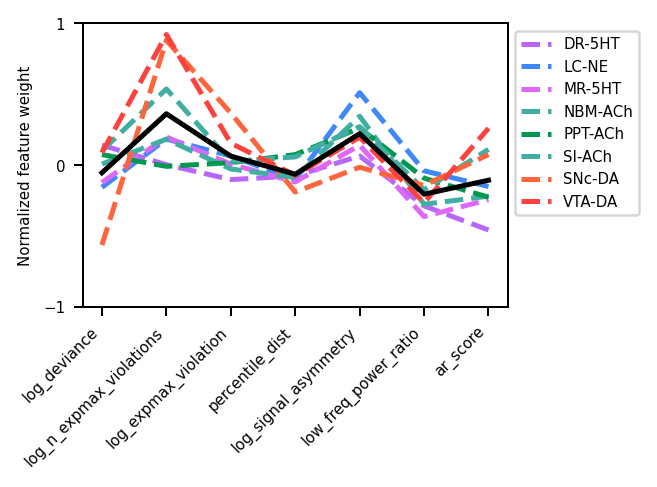

In [12]:
classes = classifier.classes_
n_classes = len(classes)
estimators = classifier.estimators_
n_features = classifier.n_features_in_

est_mat = np.full((n_classes, n_classes, n_features), np.nan)
k = 0
for i in range(n_classes):
    for j in range(n_classes):
        if j <= i: continue
        est = estimators[k]
        coefs = est.coef_.flatten()
        abs_max = np.max(np.abs(coefs))
        norm_coefs = coefs / abs_max
        est_mat[i, j] = norm_coefs
        k += 1  # increment pair-wise counter

fig, ax = plt.subplots()
# for i in range(est_mat.shape[0]):
#     for j in range(est_mat.shape[1]):
#         ax.plot(est_mat[i, j], color='gray', alpha=0.5)

for region_idx, region in enumerate(classes):
    weights = []
    for i in range(n_classes):
        for j in range(n_classes):
            if j <= i: continue
            if i == region_idx or j == region_idx:
                weights.append(est_mat[i, j])
    
    if weights:
        region_avg = np.nanmean(weights, axis=0)
        color = TARGETNM_COLORS.get(region, 'gray')
        ax.plot(region_avg, linestyle='--', linewidth=2, color=color, label=region)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.plot(np.nanmean(est_mat, axis=(0, 1)), linewidth=2, color='black')
ax.set_xticks(np.arange(len(comp_metrics)))
ax.set_xticklabels(comp_metrics, rotation=45, ha='right')
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('Normalized feature weight')

set_plotsize(w=6, h=4, ax=ax)

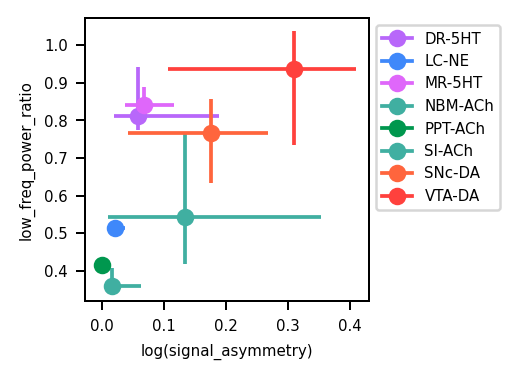

In [13]:
m0 = 'signal_asymmetry'
m1 = 'low_freq_power_ratio'

fig, ax = plt.subplots()
for target_NM, group in df_qc.groupby('target_NM'):
    
    m0_values = np.log10(group[m0]) if metric_logtransform[m0] else group[m0]
    x_neg, x, x_pos = m0_values.dropna().quantile([.25, .5, .75])
    x_neg = x - x_neg
    x_pos = x_pos - x
    
    m1_values = np.log10(group[m1]) if metric_logtransform[m1] else group[m1]
    y_neg, y, y_pos = m1_values.dropna().quantile([.25, .5, .75])
    y_neg = y - y_neg
    y_pos = y_pos - y
    
    ax.errorbar(x, y, marker='o', xerr=np.array([[x_neg], [x_pos]]), yerr=np.array([[x_neg], [x_pos]]), color=TARGETNM_COLORS[target_NM], label=target_NM)
    if metric_logtransform[m0]:
        ax.set_xlabel(f'log({m0})')
    else:
        ax.set_xlabel(m0)
    if metric_logtransform[m1]:
        ax.set_ylabel(f'log({m1})')
    else:
        ax.set_ylabel(m1)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
set_plotsize(w=4, ax=ax)
# fig.savefig('qc/figures/2dscatter.svg')

#### Fix dt_violations

In [46]:
def find_early_samples(A: pd.DataFrame | pd.Series, dt_tol: float = 0.001) -> np.ndarray:
    dt = np.median(np.diff(A.index))
    return dt - A.index.diff() > dt_tol


def _fill_missing_channel_names(A: np.ndarray) -> np.ndarray:
    missing_inds = np.where(A == '')[0]
    name_alternator = {'GCaMP': 'Isosbestic', 'Isosbestic': 'GCaMP', '': ''}
    for i in missing_inds:
        if i == 0:
            A[i] = name_alternator[A[i + 1]]
        else:
            A[i] = name_alternator[A[i - 1]]
    return A


def find_repeated_samples(
    A: pd.DataFrame,
    dt_tol: float = 0.001,
) -> int:
    if any(A['name'] == ''):
        A['name'] = _fill_missing_channel_names(A['name'].values)
    else:
        A
    repeated_sample_mask = A['name'].iloc[1:].values == A['name'].iloc[:-1].values
    repeated_samples = A.iloc[1:][repeated_sample_mask]
    dt = np.median(np.diff(A.index))
    early_samples = A[find_early_samples(A, dt_tol=dt_tol)]
    if not all([idx in early_samples.index for idx in repeated_samples.index]):
        print("WARNING: repeated samples found without early sampling")
    return repeated_sample_mask

def fix_repeated_sampling(
    A: pd.DataFrame,
    dt_tol: float = 0.001,
    w_size: int = 10,
    roi: str | None = None
) -> int:
    ## TODO: avoid this by explicitly handling multiple channels
    assert roi is not None
    # Drop first samples if channel labels are missing
    A.loc[A['name'].replace({'':np.nan}).first_valid_index():]
    # Fix remaining missing channel labels
    if any(A['name'] == ''):
        A['name'] = _fill_missing_channel_names(A['name'].values)
    repeated_sample_mask = find_repeated_samples(A, dt_tol=dt_tol)
    name_alternator = {'GCaMP':'Isosbestic', 'Isosbestic': 'GCaMP'}
    for i in (np.where(repeated_sample_mask)[0] + 1):
        name = A.iloc[i]['name']
        value = A.iloc[i][roi]
        i0, i1 = A.index[i - w_size], A.index[i]
        same = A.loc[i0:i1].query('name == @name')[roi].mean()
        other_name = name_alternator[name]
        other = A.loc[i0:i1].query('name == @other_name')[roi].mean()
        assert np.abs(value - same) > np.abs(value - other)
        A.loc[A.index[i]:, 'name'] = [name_alternator[name] for name in A.loc[A.index[i]:, 'name']]
    return A

In [197]:
session = df_targets[(df_targets['dt_violations'] > 1) & (df_targets['interleaved_acquisition'] == False)].iloc[8]
# eid = 'c5cdd496-7400-4c0f-b326-55016bce4fcf'  # cluster of spikes
# eid = 'cab30b9f-fa1d-4f39-86f2-58e9265bd9f4'  # long-term channel swap
# session = df_targets.query('eid == @eid').iloc[0]
print(session['eid'], session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

cab30b9f-fa1d-4f39-86f2-58e9265bd9f4 training


interleaved_acquisition       False
n_unique_samples              16006
f_unique_samples           0.391201
dt_violations                   279
deviance                    0.02478
n_spikes_dy                      15
expmax_violation                0.0
percentile_dist            0.516677
signal_asymmetry           0.155335
ar_score                   0.050623
Name: 194, dtype: object

In [209]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)
photometry

,Region4G,name
times,,
2988.692832,0.009247,GCaMP
2988.726176,0.022044,Isosbestic
2988.759520,0.009321,GCaMP
2988.792832,0.020027,Isosbestic
2988.826176,0.009366,GCaMP
...,...,...
5734.204288,0.017996,GCaMP
5734.237600,0.009098,Isosbestic
5734.270944,0.017975,GCaMP


In [210]:
%matplotlib tk

fig, ax = plt.subplots()
ax.plot(photometry.query('name == "GCaMP"')[session['ROI'][0]], marker='o')
ax.plot(photometry.query('name == "Isosbestic"')[session['ROI'][0]], marker='o')

In [211]:
# Check for early sampling
early_samples = find_early_samples(photometry)
early_samples.sum()

np.int64(5)

In [201]:
# Remove first samples if channel names are blank
photometry = photometry.loc[photometry['name'].replace({'':np.nan}).first_valid_index():]
_fill_missing_channel_names(photometry['name'].values)

array(['GCaMP', 'Isosbestic', 'GCaMP', ..., 'GCaMP', 'Isosbestic',
       'GCaMP'], dtype=object)

In [202]:
repeated_sample_mask = find_repeated_samples(photometry)
repeated_sample_mask.sum()

np.int64(3)

             Region4G        name
times                            
3235.851360  0.020202  Isosbestic
3235.884672  0.010417       GCaMP
3235.909056  0.020191       GCaMP
3235.918016  0.010425  Isosbestic
             Region4G        name
times                            
3523.775264  0.010109  Isosbestic
3523.808576  0.019644       GCaMP
3523.812768  0.010013       GCaMP
3523.812832  0.019665       GCaMP
             Region4G        name
times                            
3523.808576  0.019644       GCaMP
3523.812768  0.010013       GCaMP
3523.812832  0.019665       GCaMP
3523.841920  0.009957  Isosbestic


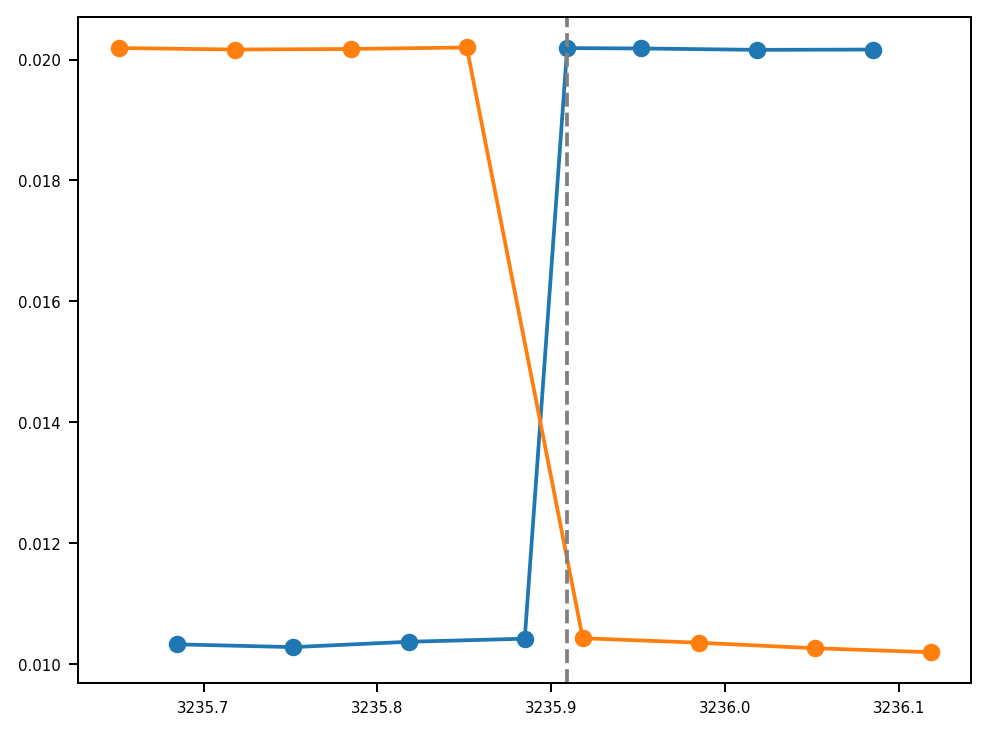

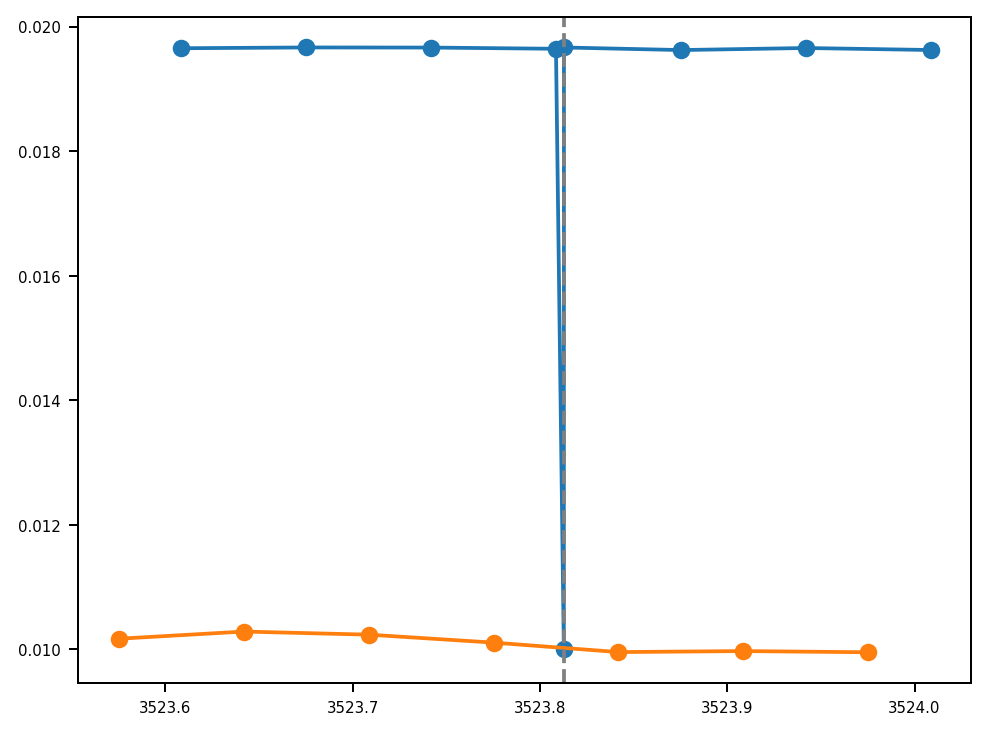

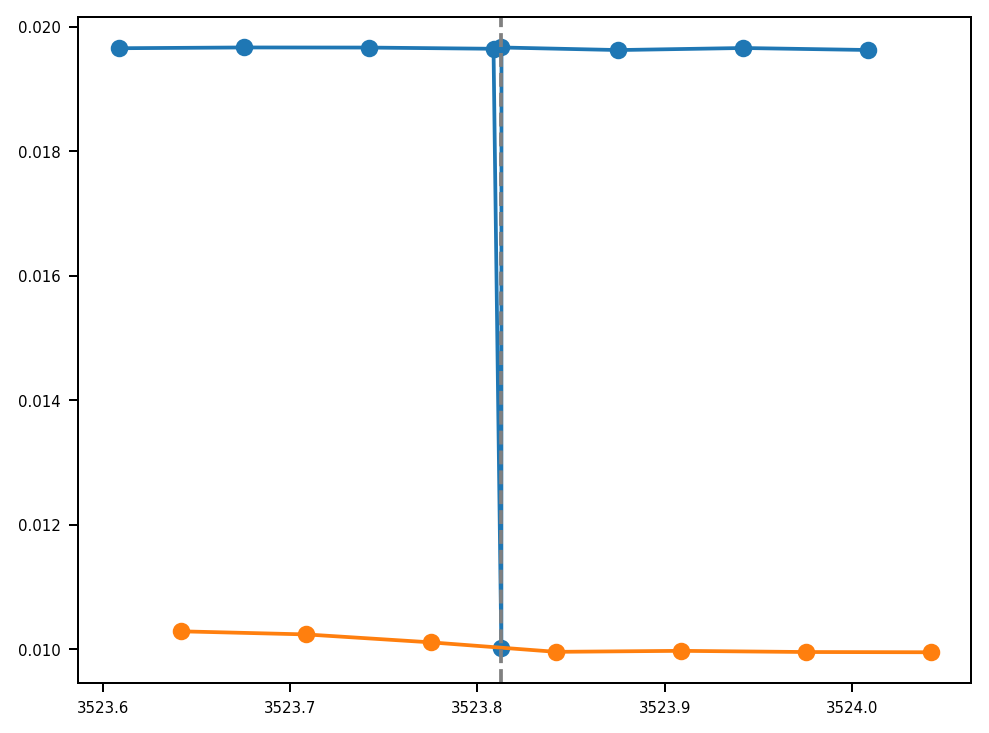

In [203]:
%matplotlib inline

for i in np.where(repeated_sample_mask)[0] + 1:
    print(photometry.iloc[(i - 2):(i + 2)])
    fig, ax = plt.subplots()
    ax.plot(photometry.iloc[(i - 8):(i + 8)].query('name == "GCaMP"')[session['ROI'][0]], marker='o')
    ax.plot(photometry.iloc[(i - 8):(i + 8)].query('name == "Isosbestic"')[session['ROI'][0]], marker='o')
    ax.axvline(photometry.index[i], ls='--', color='gray')

In [204]:
photometry_fixed = fix_repeated_sampling(photometry, roi=session['ROI'][0])

             Region4G        name
times                            
3235.851360  0.020202  Isosbestic
3235.884672  0.010417       GCaMP
3235.909056  0.020191  Isosbestic
3235.918016  0.010425       GCaMP
             Region4G        name
times                            
3523.775264  0.010109       GCaMP
3523.808576  0.019644  Isosbestic
3523.812768  0.010013       GCaMP
3523.812832  0.019665  Isosbestic
             Region4G        name
times                            
3523.808576  0.019644  Isosbestic
3523.812768  0.010013       GCaMP
3523.812832  0.019665  Isosbestic
3523.841920  0.009957       GCaMP


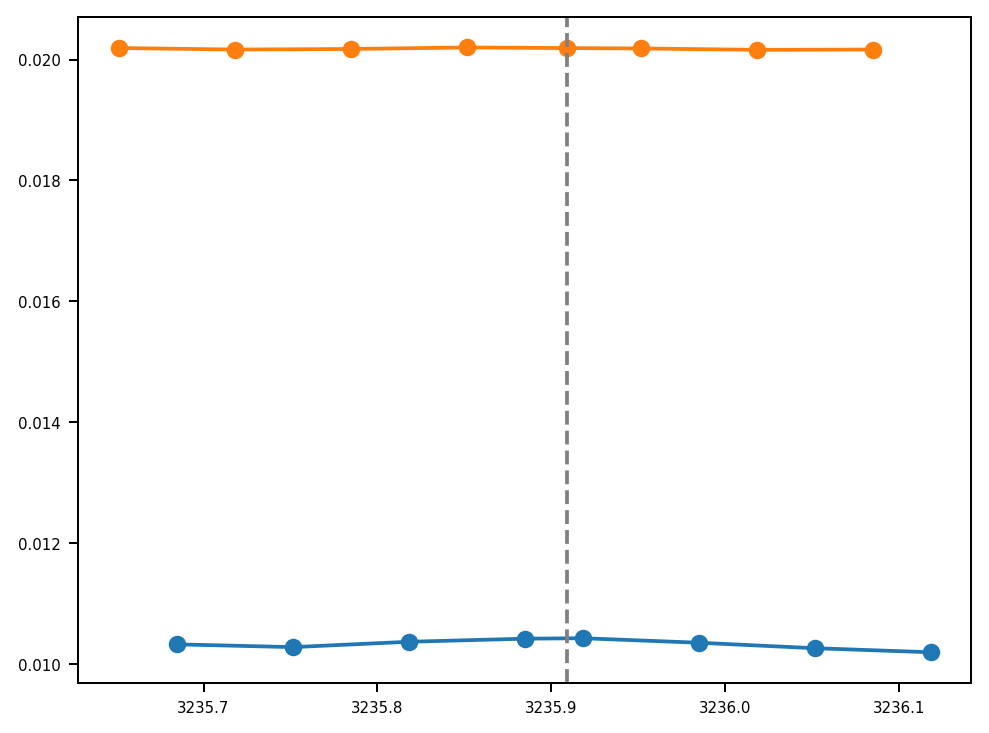

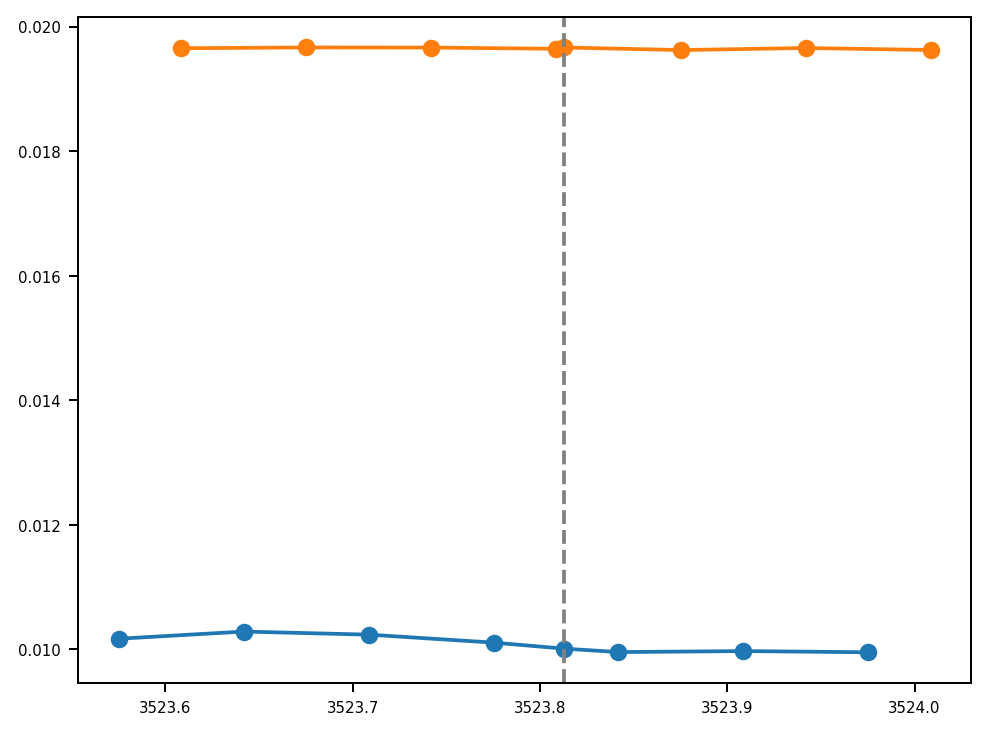

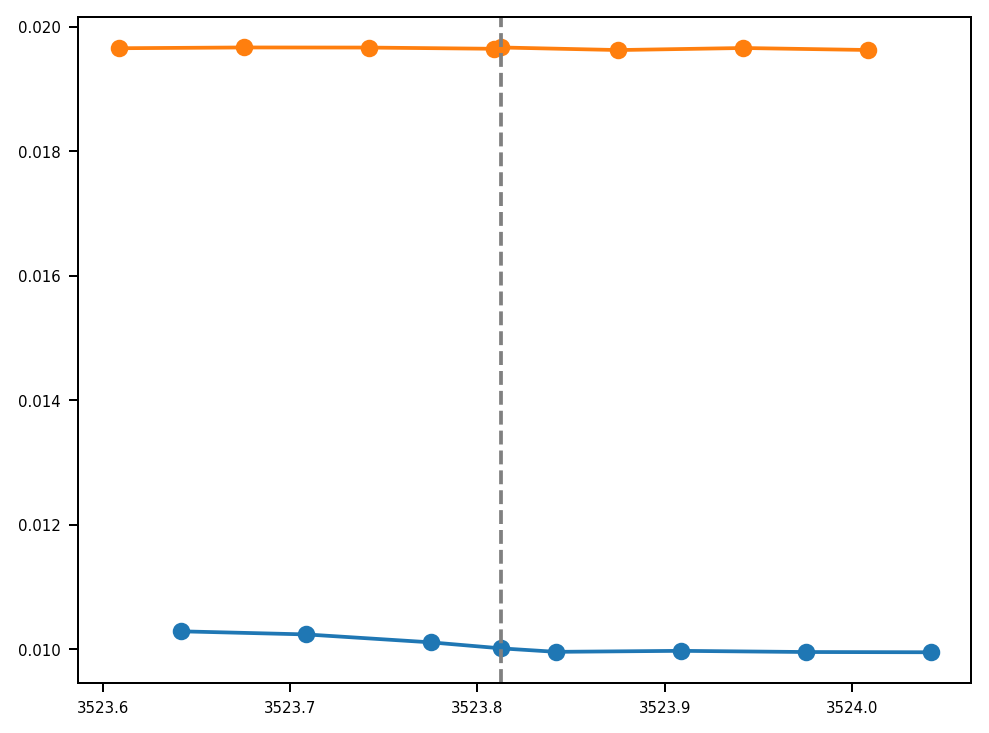

In [205]:
%matplotlib inline

for i in np.where(repeated_sample_mask)[0] + 1:
    print(photometry_fixed.iloc[(i - 2):(i + 2)])
    fig, ax = plt.subplots()
    ax.plot(photometry_fixed.iloc[(i - 8):(i + 8)].query('name == "GCaMP"')[session['ROI'][0]], marker='o')
    ax.plot(photometry_fixed.iloc[(i - 8):(i + 8)].query('name == "Isosbestic"')[session['ROI'][0]], marker='o')
    ax.axvline(photometry_fixed.index[i], ls='--', color='gray')

In [212]:
gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')

In [214]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 3200, 3600

i0, i1 = iso.index.values.searchsorted([t0, t1])
ax.plot(iso.iloc[i0:i1][session['ROI'][0]], color='gray', label='Isosbestic')
i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
ax.set_ylabel('Signal (a.u.)')
# ax.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title(f"{session['target_NM']}", fontsize=8)
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/spikes_signal.svg')

In [147]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 1872.6, 1873.2

i0, i1 = iso.index.values.searchsorted([t0, t1])
ax.plot(iso.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color='gray', label='Isosbestic')
i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
ax.set_ylabel('Signal (a.u.)')
set_plotsize(w=2.5, h=2, ax=ax)
fig.savefig('qc/figures/spikes_zoom.svg')

In [215]:
photometry_fixed = fix_repeated_sampling(photometry, roi=session['ROI'][0])
gcamp = photometry_fixed.query('name == "GCaMP"')
iso = photometry_fixed.query('name == "Isosbestic"')

In [150]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 1872.6, 1873.2

i0, i1 = iso.index.values.searchsorted([t0, t1])
ax.plot(iso.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color='gray', label='Isosbestic')
i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.set_yticklabels([])
set_plotsize(w=2.5, h=2, ax=ax)
fig.savefig('qc/figures/spikes_fixed.svg')

In [23]:
gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')
F = gcamp[session['ROI']]
F_iso = iso[session['ROI']]

In [24]:
%matplotlib tk
plt.plot(F, marker='o', color='black')
plt.plot(F_iso, marker='o', color='gray')

In [4]:
one_remote = ONE()

In [ ]:
one_local = ONE(cache_dir='/home/crombie/mnt/ccu-iblserver')

In [5]:
session = df_qc[df_qc['n_unique_samples'] > 100].iloc[-4]
# eid = 'e898dfa4-f21d-42d6-81d4-9bf4f3e577bf'  # good low n example
# eid = 'a44f72af-755f-4d58-b9bb-c5b345bcd788'  # good low n, high amp example
# session = df_targets.query('eid == @eid').iloc[0]
print(session['target_NM'], session['eid'], session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

LC-NE 60463bc3-efa2-44d1-bd9e-51841b491ebe training


n_early_samples                0
n_repeated_samples             0
n_unique_samples            3391
f_unique_samples        0.030952
deviance                0.028807
n_expmax_violations            0
expmax_violation             0.0
percentile_dist         2.443374
signal_asymmetry        2.963087
low_freq_power_ratio    0.675384
ar_score                0.417057
Name: 675, dtype: object

In [6]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    # photometry = load_photometry_data(session, one_local, extracted=False)
    pass
photometry

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


,G1,name
times,,
-28.319829,0.003922,
-28.303190,0.017590,GCaMP
-28.286518,0.017560,Isosbestic
-28.269878,0.017492,GCaMP
-28.253206,0.017413,Isosbestic
...,...,...
3702.929914,0.011405,Isosbestic
3702.946585,0.013106,GCaMP
3702.963225,0.011368,Isosbestic


In [10]:
%matplotlib tk

fig, ax = plt.subplots()
ax.plot(photometry.query('name == "GCaMP"')[session['roi']])

In [270]:
gcamp = photometry.query('name == "GCaMP"')

In [271]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 1400, 1460

i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['roi'], color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-3, 3])
ax.set_ylabel('Signal (a.u.)')
# ax.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title(f"{session['target_NM']}, n_unique_samples={session['n_unique_samples']}")
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/nunique_high.svg')

In [11]:
def psth(F, ts, t0=0.1, t1=1):
    tpts = F.index.values
    ts = ts[(ts - t0 > tpts.min()) & (ts + t1 < tpts.max())]
    inds = tpts.searchsorted(ts)
    dt = np.median(np.diff(tpts))
    i0s = inds - int(t0 // dt)
    i1s = inds + int(t1 // dt)
    responses = np.stack([F.values[i0:i1] for i0, i1 in zip(i0s, i1s)])
    tpts_resp = np.linspace(-1 * t0, t1, responses.shape[1])
    responses = (responses.T - responses[:, tpts_resp.searchsorted(0)]).T
    return responses, tpts_resp


### Pair-wise metric evaluation

In [12]:
# Remove obviously bad recordings
df = df_targets[df_targets['n_unique_samples'] > 100].copy()

In [16]:
from matplotlib.patches import Rectangle

In [74]:
for metric in raw_metrics + sliding_metrics + processed_metrics:
    df[f'log_{metric}'] = np.log10(df[metric])

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
metrics = ['log_deviance', 'ar_score']
df[metrics] = df[metrics].replace({np.inf:np.nan, -np.inf:np.nan})
df = df.dropna(subset=metrics).dropna()

D, x_bins, y_bins = np.histogram2d(df[metrics[0]], df[metrics[1]], bins=16)

w = 3
ix0, iy0 = 8, 13
ix1, iy1 = ix0 + w, iy0 + w

/tmp/ipykernel_141462/1759412362.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(D.T), cmap='YlOrBr')


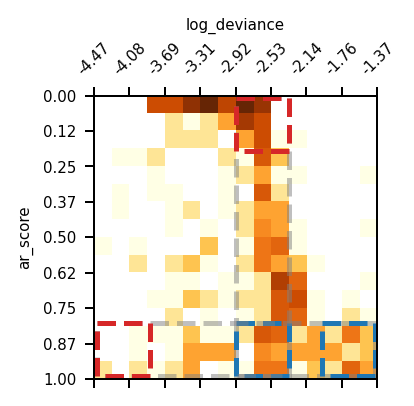

In [124]:
%matplotlib inline

fig, ax = plt.subplots()
ax.matshow(np.log10(D.T), cmap='YlOrBr')

ax.add_patch(
    Rectangle((ix0 - 0.5, -0.35), (ix1 - ix0), len(y_bins) - 1.3, fc='none', ec='gray', alpha=0.5, ls='--', lw=2)
)
ax.add_patch(
    Rectangle((ix0 - 0.5, -0.35), (ix1 - ix0), 3, fc='none', ec='tab:red', ls='--', lw=2)
)
ax.add_patch(
    Rectangle((ix0 - 0.5, 12.35), (ix1 - ix0), 3, fc='none', ec='tab:blue', ls='--', lw=2)
)


ax.add_patch(
    Rectangle((-0.35, iy0 - 0.65), len(x_bins) - 1.3, (iy1 - iy0), fc='none', ec='gray', alpha=0.5, ls='--', lw=2)
)
ax.add_patch(
    Rectangle((-0.35, iy0 - 0.65), 3, (iy1 - iy0), fc='none', ec='tab:red', ls='--', lw=2)
)
ax.add_patch(
    Rectangle((12.35, iy0 - 0.65), 3, (iy1 - iy0), fc='none', ec='tab:blue', ls='--', lw=2)
)

ax.set_xticks(np.arange(len(x_bins))[::2] - 0.5)
ax.set_xticklabels([f'{x:.2f}' for x in x_bins[::2]])
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel(metrics[0])
ax.xaxis.set_label_position('top')
ax.set_yticks(np.arange(len(y_bins))[::2] - 0.5)
ax.set_yticklabels([f'{y:.2f}' for y in y_bins[::2]])
ax.set_ylabel(metrics[1])
set_plotsize(w=4, ax=ax)

fig.savefig('qc/figures/metrics_joint.svg')

In [18]:
def sample_from_bin_2d(df, ranges):
    (m0, m0_range), (m1, m1_range) = ranges.items()
    m0_mask = (df[m0] >= m0_range[0]) & (df[m0] <= m0_range[1])
    m1_mask = (df[m1] >= m1_range[0]) & (df[m1] <= m1_range[1])
    return df[m0_mask & m1_mask]

In [59]:
ranges = {
    metrics[0]: (x_bins[13], x_bins[16]),
    metrics[1]: (y_bins[iy0], y_bins[iy1])
}
df_samples = sample_from_bin_2d(df, ranges)
len(df_samples)

33

In [60]:
session_idx = np.random.choice(df_samples.index)
session = df_samples.loc[session_idx]
# eid = 'a7366bb4-8e5d-44fc-97f8-af129659b9c6'  # bad ar_score
# eid = '87a8de43-8576-450c-be35-4fccaa4e1d14'  # good ar_score
# eid = 'aa211f0c-94df-4f8a-9775-b8fcec3f5138'  # bad deviance
# session = df_samples[df_samples['eid'] == eid].iloc[0]
print(session['target_NM'], session['eid'], session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

VTA-DA db14d055-31c5-4a7e-a09a-3ab89aafa473 biased


n_early_samples                6
n_repeated_samples             3
n_unique_samples           14285
f_unique_samples         0.12176
deviance                0.018508
n_expmax_violations        241.0
expmax_violation        0.000275
percentile_dist         1.866149
signal_asymmetry        1.721961
low_freq_power_ratio    0.916214
ar_score                0.821469
Name: 282, dtype: object

In [61]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)

gcamp = photometry.query('name == "GCaMP"')
F = gcamp[session['ROI']]

In [65]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 2550, 2610
i0, i1 = F.index.values.searchsorted([t0, t1])

ax.plot(F.iloc[i0:i1], color=colors[session['target_NM']], label='GCaMP raw')
# ax.plot(F, color=colors[session['target_NM']], label='GCaMP raw')
ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
ax.set_ylabel('Signal (a.u.)')
ax.set_title(f"{session['target_NM']} - GCaMP raw")
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/deviance_good_signal.svg')

## Combine QC metrics

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


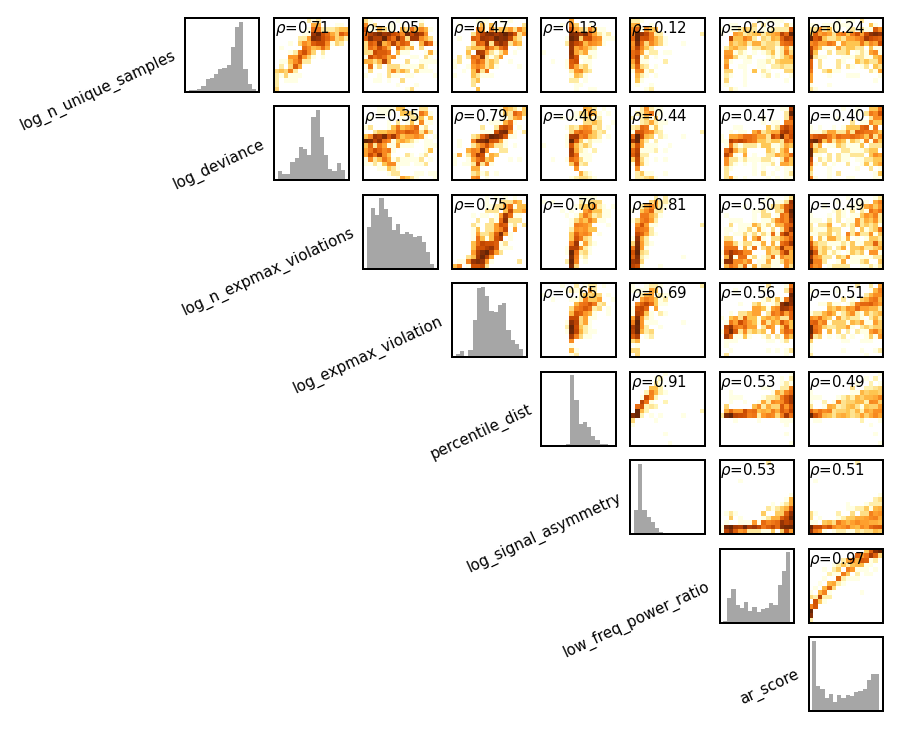

In [14]:
for metric in raw_metrics + sliding_metrics + processed_metrics:
    df_qc[f'log_{metric}'] = np.log10(df_qc[metric]).replace({np.inf:np.nan, -np.inf:np.nan})

comp_metrics = [
    'log_n_unique_samples',
    'log_deviance',
    'log_n_expmax_violations',
    'log_expmax_violation',
    'percentile_dist',
    'log_signal_asymmetry',
    'low_freq_power_ratio',
    'ar_score'
]

%matplotlib inline
fig, X = plot_joint_distributions(df_qc[comp_metrics], transform=False, bins=16)
# fig.savefig('qc/figures/corrmat.svg')

0.8059112040708482


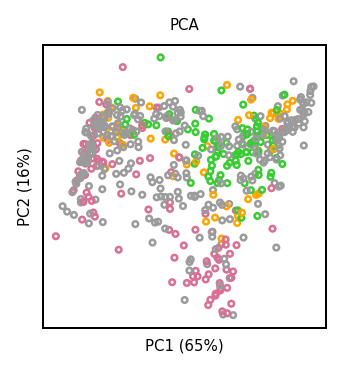

In [29]:
df_qclabels = pd.read_csv('metadata/recordings.csv').set_index('eid')
def label2val(label):
    return {'CRITICAL': 0.1, 'TO_CHECK': 0.66, 'PASS': 0.99}.get(label, 0.01)
df_qclabels['qc_val'] = df_qclabels['GC_label'].map(label2val)
df_qc['qc_val'] = df_qc['eid'].apply(lambda eid: df_qclabels.loc[eid]['qc_val'] if eid in df_qclabels.index else 0.01)

nan_mask = df_qc[comp_metrics].notna().all(axis=1)
X = df_qc[comp_metrics][nan_mask].values
scaler = MinMaxScaler()
pca = PCA(n_components=2)
Xpc = pca.fit_transform(scaler.fit_transform(X))
print(sum(pca.explained_variance_ratio_))

fig, ax = plt.subplots()
colors
ax.scatter(Xpc[:, 0], Xpc[:, 1], s=5, fc='none', ec=[QCCMAP(val) for val in df_qc[nan_mask]['qc_val']])
ax.set_xticks([])
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.0f}%)')
ax.set_yticks([])
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.0f}%)')
ax.set_title('PCA')
set_plotsize(w=4, ax=ax)

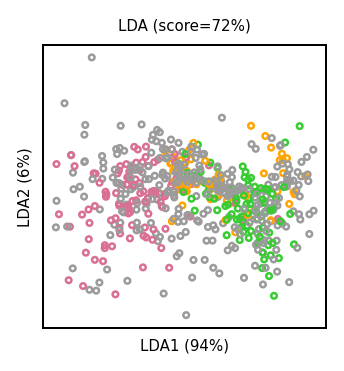

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Feature matrix
X = df_qc[comp_metrics][nan_mask].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Get corresponding labels
labels = df_qc.loc[nan_mask, 'eid'].map(
    lambda eid: df_qclabels.loc[eid]['GC_label'] if eid in df_qclabels.index else None
)

# Training mask for LDA (only 'PASS' and 'CRITICAL')
lda_mask = labels.isin(['PASS', 'TO_CHECK', 'CRITICAL'])
X_train = X_scaled[lda_mask.values]
y_train = labels[lda_mask].values

# Fit LDA on 'PASS' vs 'CRITICAL'
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)

# Project all samples onto the learned LDA axis
X_lda = lda.transform(X_scaled)

# Plot projection vs itself, colored by qc_val
fig, ax = plt.subplots()
ax.scatter(X_lda[:, 0], X_lda[:, 1], s=5, fc='none', ec=[QCCMAP(val) for val in df_qc.loc[nan_mask, 'qc_val']])
ax.set_xlabel(f'LDA1 ({lda.explained_variance_ratio_[0] * 100:.0f}%)')
ax.set_ylabel(f'LDA2 ({lda.explained_variance_ratio_[1] * 100:.0f}%)')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'LDA (score={lda.score(X_train, y_train) * 100:.0f}%)')
set_plotsize(w=4, ax=ax)

In [29]:
%matplotlib inline

events_colors = {'cue': 'black', 'movement': 'black', 'reward': 'black', 'omission':'gray'}

psths = []
y_max = 0
for event in events_colors.keys():
    responses, tpts = psth(F[session['ROI'][0]], session[f'{event}_times'])
    psths.append(responses)
    resp_max = np.abs(responses.mean(axis=0)).max()
    y_max = resp_max if resp_max > y_max else y_max
y_max += y_max / 10
y_max = 2e-6

# for responses, (event, color) in zip(psths, events_colors.items()):
for responses, event in zip(psths, events_colors.keys()):
    if not event == 'omission':
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(tpts, responses.mean(axis=0), color=colors[session['target_NM']], label=event)
    ax.plot(tpts, responses.mean(axis=0) - stats.sem(responses, axis=0), ls='--', color=colors[session['target_NM']])
    ax.plot(tpts, responses.mean(axis=0) + stats.sem(responses, axis=0), ls='--', color=colors[session['target_NM']])
    ax.axvline(0, ls='--', color='black', alpha=0.5)
    ax.axhline(0, ls='--', color='gray', alpha=0.5)
    ax.set_xlabel('Time (s)')
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), frameon=False)
    if not event == 'omission':
        ax.set_title(event.capitalize())
    set_plotsize(1.5, ax=ax)
    if event == 'cue':
        ax.set_yticks([-1 * y_max, 0, y_max])
        # ax.set_yticklabels([f'{tick:.2e}' for tick in ax.get_yticks()])
        ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
        ax.set_ylabel('Response (a.u.)')
    else:
        ax.set_ylim([-1 * y_max, y_max])
        ax.set_yticks([])
    fig.savefig(f'qc/figures/arscore_bad_{event}.svg')

ValueError: need at least one array to stack

> /home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/shape_base.py(444)stack()
    442     arrays = [asanyarray(arr) for arr in arrays]
    443     if not arrays:
--> 444         raise ValueError('need at least one array to stack')
    445 
    446     shapes = {arr.shape for arr in arrays}



ipdb>  u


> /tmp/ipykernel_141462/3923110604.py(8)psth()
      6     i0s = inds - int(t0 // dt)
      7     i1s = inds + int(t1 // dt)
----> 8     responses = np.stack([F.values[i0:i1] for i0, i1 in zip(i0s, i1s)])
      9     tpts_resp = np.linspace(-1 * t0, t1, responses.shape[1])
     10     responses = (responses.T - responses[:, tpts_resp.searchsorted(0)]).T



ipdb>  t0


0.1


ipdb>  ts


array([], dtype=float64)


ipdb>  c


In [30]:
session

NM                                                                           5HT
ROI                                                                   [Region3G]
_deviance_p                                                             0.000001
_deviance_r                                                            -0.630668
_deviance_times                [10663.836064, 10723.800896, 10783.765664, 108...
_deviance_values               [0.007208846584536928, 0.004992387494251136, 0...
_expmax_violation_p                                                     0.101476
_expmax_violation_r                                                     0.229649
_expmax_violation_times        [10663.836064, 10723.800896, 10783.765664, 108...
_expmax_violation_values       [1.8280024726069141e-06, 0.0, 0.0, 0.0, 0.0, 0...
_n_expmax_violations_p                                                  0.175297
_n_expmax_violations_r                                                  0.190864
_n_expmax_violations_times  

#### Deviance

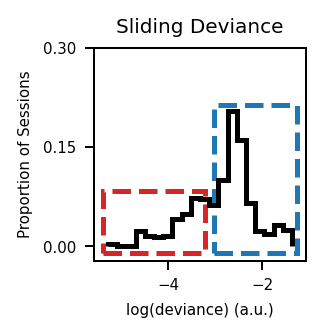

In [480]:
%matplotlib inline
fig, ax = plt.subplots()

data = df_targets['deviance']
data = np.log10(df_targets['deviance'][df_targets['deviance'] > 0])
weights = np.ones_like(data) / len(data)
counts, bins, _ = ax.hist(data, weights=weights, bins=20, histtype='step', linewidth=2, color='black')
good = Rectangle(
    (bins[12] - 0.1, -0.01), (bins[20] - bins[12] + 0.2), counts[12:20].max() + 0.02,
    fc='none', ec='tab:blue', ls='--', lw=2
)
ax.add_patch(good)
bad = Rectangle(
    (bins[0] - 0.1, -0.01), (bins[10] - bins[0] + 0.2), counts[:10].max() + 0.02,
    fc='none', ec='tab:red', ls='--', lw=2
)
ax.add_patch(bad)
# ax.set_xticklabels(['$10^{%.2f}$' % tick for tick in ax.get_xticks()])
ax.set_xlabel('log(deviance) (a.u.)')
ax.set_yticks([0, 0.15, 0.3])
ax.set_ylabel('Proportion of Sessions')
ax.set_title('Sliding Deviance', fontsize=8)
set_plotsize(w=3, ax=ax)
fig.savefig('qc/figures/deviance.svg')

In [488]:
# Bad values
cutoff = 10 ** bins[10]
df_metric = df_targets[df_targets['deviance'] < cutoff]
print(cutoff, len(df_metric))

0.00047346076945458304 186


In [489]:
session = df_metric.iloc[111].copy()
print(session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

biased


interleaved_acquisition        True
n_unique_samples               2028
f_unique_samples           0.011706
dt_violations                     0
deviance                   0.000413
n_spikes_dy                0.363636
expmax_violation           0.000001
percentile_dist            1.687129
signal_asymmetry           4.077381
ar_score                   0.000281
Name: 590, dtype: object

In [490]:
# Good values
cutoff = 10 ** bins[12]
df_metric = df_targets[df_targets['deviance'] > cutoff]
print(cutoff, len(df_metric))

0.001164859999255469 410


In [491]:
session = df_metric.iloc[12].copy()
print(session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

training


interleaved_acquisition         True
n_unique_samples               15646
f_unique_samples            0.360889
dt_violations                    333
deviance                    0.031359
n_spikes_dy                10.333333
expmax_violation            0.000187
percentile_dist             1.980185
signal_asymmetry             1.64887
ar_score                    0.844004
Name: 22, dtype: object

In [492]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)

gcamp = photometry.query('name == "GCaMP"')
F = gcamp[session['ROI']]

pipeline = [
    (proc.remove_spikes, {'delta': 't'}),
    (proc.sliding_robust_zscore, {'w_len': 10})
]

F_proc = pipelines.run_pipeline(pipeline, F).dropna()

In [493]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 4100, 4160
i0, i1 = F_proc.index.values.searchsorted([t0, t1])

ax.plot(F.iloc[i0:i1], color=colors[session['target_NM']], label='GCaMP raw')
# ax.plot(F, color=colors[session['target_NM']], label='GCaMP raw')
# ax.plot(F_proc.iloc[i0:i1], color=colors[session['target_NM']], label='GCaMP processed')
ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
# ax.set_yticklabels(f'{tick:.2e}' for tick in ax.get_yticks())
ax.set_ylabel('Signal (a.u.)')
# ax.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title(f"{session['target_NM']} - {session['session_type']} session - GCaMP raw", fontsize=8)
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/deviance_good_signal.svg')

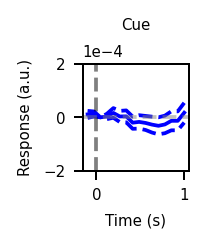

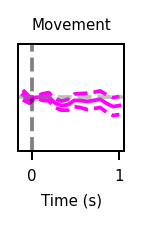

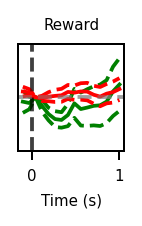

In [503]:
%matplotlib inline

session = _load_event_times(session, one_remote)
events_colors = {'cue': 'blue', 'movement': 'magenta', 'reward': 'green', 'omission':'red'}

psths = []
y_max = 0
for event in events_colors.keys():
    responses, tpts = psth(F[session['ROI'][0]], session[f'{event}_times'])
    psths.append(responses)
    resp_max = np.abs(responses.mean(axis=0)).max()
    y_max = resp_max if resp_max > y_max else y_max
y_max += y_max / 10
y_max = 2e-4

for responses, (event, color) in zip(psths, events_colors.items()):
    if not event == 'omission':
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(tpts, responses.mean(axis=0), color=color, label=event)
    ax.plot(tpts, responses.mean(axis=0) - stats.sem(responses, axis=0), ls='--', color=color)
    ax.plot(tpts, responses.mean(axis=0) + stats.sem(responses, axis=0), ls='--', color=color)
    ax.axvline(0, ls='--', color='black', alpha=0.5)
    ax.axhline(0, ls='--', color='gray', alpha=0.5)
    ax.set_xlabel('Time (s)')
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), frameon=False)
    if not event == 'omission':
        ax.set_title(event.capitalize())
    set_plotsize(1.5, ax=ax)
    if event == 'cue':
        ax.set_yticks([-1 * y_max, 0, y_max])
        # ax.set_yticklabels([f'{tick:.2e}' for tick in ax.get_yticks()])
        ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
        ax.set_ylabel('Response (a.u.)')
    else:
        ax.set_ylim([-1 * y_max, y_max])
        ax.set_yticks([])
    fig.savefig(f'qc/figures/deviance_good_{event}.svg')

### Interleaved acquisition

In [504]:
df = df_targets[~df_targets['interleaved_acquisition'] & (df_targets['dt_violations'] % 2 == 0)]
print(len(df))

58


In [505]:
session = df.iloc[5]
photometry = load_photometry_data(session, one_local, extracted=False)
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

interleaved_acquisition       False
n_unique_samples               9608
f_unique_samples           0.204356
dt_violations                   472
deviance                    0.00162
n_spikes_dy                0.444444
expmax_violation           0.000011
percentile_dist            1.728901
signal_asymmetry           2.527751
ar_score                   0.122949
Name: 210, dtype: object

In [506]:
%matplotlib tk
fig, ax = plt.subplots(figsize=(6, 4))

gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')
ax.plot(iso[session['ROI'][0]], marker='o', color='gray', label='Isosbestic')
ax.plot(gcamp[session['ROI'][0]], marker='o', color=colors[session['target_NM']], label='GCaMp')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)


In [208]:
df = df_targets[df_targets['n_unique_samples'] < 1000]
print(len(df))

144


In [216]:
session = df.iloc[2]
photometry = load_photometry_data(session, one_local, extracted=False)
session[['eid'] + csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

eid                        4ea40125-7240-47e6-ac35-bb59dc8ad86f
interleaved_acquisition                                    True
n_unique_samples                                            358
f_unique_samples                                       0.005279
dt_violations                                               744
deviance                                                    0.0
n_spikes_dy                                                 298
expmax_violation                                       0.000005
percentile_dist                                        3.083899
signal_asymmetry                                            inf
low_freq_power_ratio                                    0.43567
ar_score                                              -0.000184
Name: 113, dtype: object

In [218]:
%matplotlib tk
fig, ax = plt.subplots(figsize=(6, 4))

gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')
ax.plot(gcamp[session['ROI'][0]], color=colors[session['target_NM']], label='GCaMP')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)


In [242]:
df_targets['expmax_violation'] > 

(array([528.,  18.,  11.,   2.,   1.,   1.,   1.,   1.,   0.,   4.]),
 array([0.        , 0.00011693, 0.00023385, 0.00035078, 0.0004677 ,
        0.00058463, 0.00070155, 0.00081848, 0.0009354 , 0.00105233,
        0.00116925]),
 <BarContainer object of 10 artists>)

In [20]:
pipeline = [
    (proc.remove_spikes, {'delta': 't'}),
    (proc.sliding_robust_zscore, {'w_len': 5})
]

In [25]:
session = df.iloc[215]
photometry = load_photometry_data(session, one_local, extracted=False)
session[csv_metrics + raw_metrics + processed_metrics]

dt_violations                     0
interleaved_acquisition        True
n_unique_samples              11193
f_unique_samples           0.113472
n_spikes_dy                       1
n_outliers                       25
expmax_violation           0.000189
deviance                   0.032317
percentile_dist            2.192259
low_freq_power_ratio       0.998687
ar_score                   0.997834
Name: 738, dtype: object

In [54]:
from util import _load_event_times

In [55]:
df_qc.apply(_load_event_times, one=one, axis='columns')

,NM,_ar_score_p,_ar_score_r,_ar_score_times,_ar_score_values,_deviance_p,_deviance_r,_deviance_times,_deviance_values,_expmax_violation_p,...,omission_times,percentile_dist,reward_times,roi,session_type,signal_asymmetry,start_time,strain,subject,targeted_regions
0,5HT,2.176503e-08,-0.526494,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.901345159747499, 0.9464004901722167, 0.9305...",1.165786e-05,-0.424925,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.01443873807776788, 0.007074552594503888, 0....",2.351264e-02,...,"[29.9421, 37.605000000000004, 73.5354999999999...",1.003948,"[14.071900000000001, 24.877200000000002, 48.01...",Region4G,training,0.368425,2021-08-27T10:14:49.383803,Ai148xSERTCre,ZFM-03062,[MR]
1,5HT,5.769312e-02,-0.191422,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.8600880109684149, 0.8794683496929634, 0.881...",9.637370e-10,-0.566766,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.03385050292551421, 0.03301896291323814, 0.0...",1.332652e-03,...,"[18.6195, 49.6135, 59.996899, 73.4806000000000...",1.808537,"[8.909600000000001, 11.6724, 135.7933000000000...",Region1G,training,1.699016,2021-08-27T10:18:12.784055,Ai148xSERTCre,ZFM-03065,[DR]
2,5HT,1.836522e-02,-0.241547,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.791876175048804, 0.9366743300464845, 0.8843...",8.324779e-04,-0.337221,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.007340395732002399, 0.008169532373635201, 0...",8.206175e-02,...,"[25.950298999999998, 36.1976, 44.3807, 59.8447...",1.984716,"[14.3543, 19.943799999999996, 64.1746, 83.0249...",Region1G,training,1.828710,2021-08-27T11:18:32.529960,Ai148xSERTCre,ZFM-03059,[DR]
3,5HT,8.851599e-14,-0.672107,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[-0.08605383761468866, -0.5172052236638258, -0...",9.168165e-02,-0.174022,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.00035127434526441417, 0.0003513291954569089...",3.755670e-02,...,NaN,2.010618,NaN,Region4G,habituation,222.888406,2021-08-27T11:23:53.754095,Ai148xSERTCre,ZFM-03061,"[DR, MR]"
4,5HT,1.682220e-17,-0.736970,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.013373687410070056, -0.3908831440827607, -0...",5.612556e-08,-0.522467,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.0005491703604989111, 0.0004709576138320842,...",2.771763e-01,...,NaN,2.210126,NaN,Region6G,habituation,149.434109,2021-08-27T11:23:53.754095,Ai148xSERTCre,ZFM-03061,"[DR, MR]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,none,2.147075e-29,-0.874505,"[57.912820281528184, 87.877898492236, 117.8429...","[0.958789597054216, 0.9156390309867528, 0.9041...",1.105848e-11,-0.640055,"[57.912820281528184, 87.877898492236, 117.8429...","[0.005530027252296051, 0.003794533061623815, 0...",5.090685e-02,...,"[32.699799999999996, 53.502599999999994, 61.93...",2.194243,"[39.7378, 44.521499999999996, 48.5629, 66.0497...",G4,training,2.152759,2024-11-05T15:28:52.921000,B6.Cg,CQ002,[]
979,none,6.398447e-02,-0.198324,"[278.49746608083626, 308.46262089412596, 338.4...","[-0.4237746203043762, -0.4167997408659607, -0....",2.544897e-04,-0.380573,"[278.49746608083626, 308.46262089412596, 338.4...","[0.0003285798777726404, 0.0003286338690108921,...",4.556092e-01,...,"[256.927699, 271.53969900000004, 284.404399000...",1.741417,"[251.32769899999997, 261.943299, 268.223799000...",G0,training,1.292453,2024-11-07T15:15:38.587000,B6.Cg,CQ001,[]
980,none,1.016015e-17,-0.759236,"[278.49746608083626, 308.46262089412596, 338.4...","[0.9495966730337208, 0.915892129121367, 0.8909...",2.391103e-28,-0.871500,"[278.49746608083626, 308.46262089412596, 338.4...","[0.008317025440310113, 0.005148342059341304, 0...",3.980689e-08,...,"[256.927699, 271.53969900000004, 284.404399000...",2.579287,"[251.32769899999997, 261.943299, 268.223799000...",G4,training,5.146939,2024-11-07T15:15:38.587000,B6.Cg,CQ001,[]
981,none,2.063082e-28,-0.881214,"[219.5858441220089, 249.55089014542773, 279.51...","[

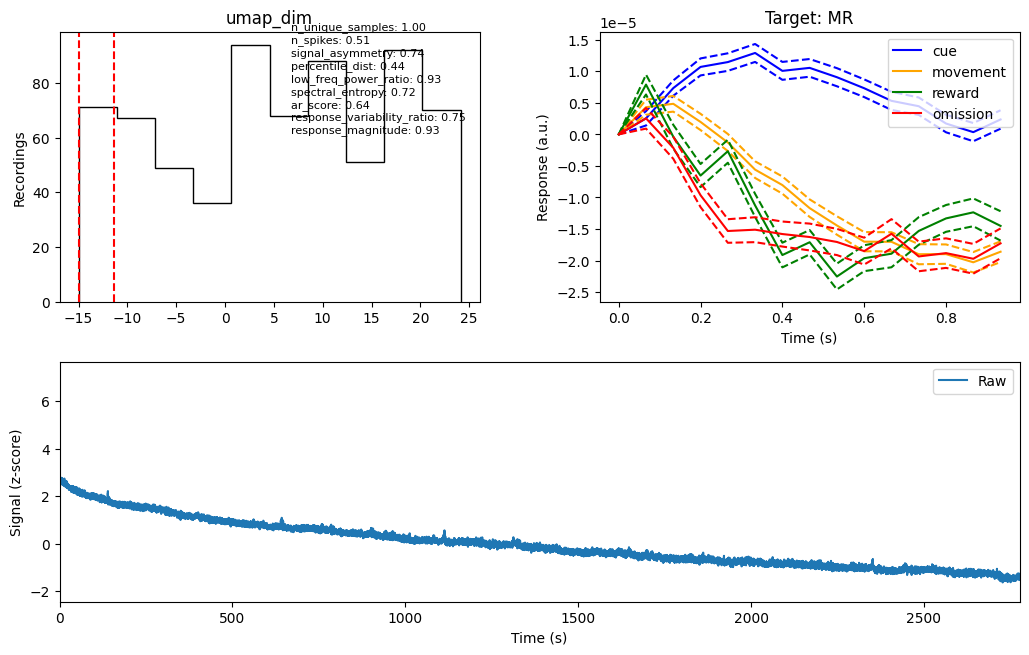

In [332]:
# Pick an event
metric = 'umap_dim'
fig, ax = plot_qc_example(df_metrics, metric, percentile_range=[0, 10]) 

In [237]:
df_metrics = df_metrics.dropna(subset=metrics_dict.keys())

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


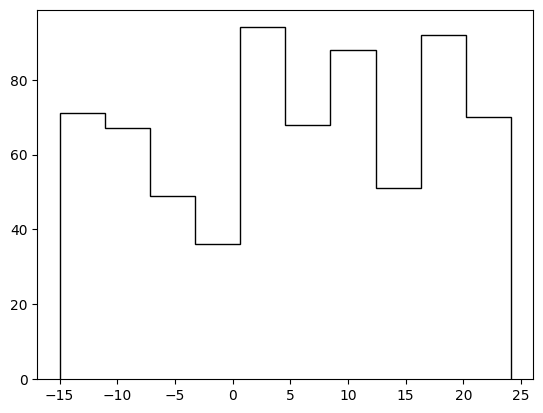

In [322]:
metrics_list = [
    'n_unique_samples',
    # 'n_spikes',
    'signal_asymmetry',
    'percentile_dist',
    'low_freq_power_ratio',
    # 'spectral_entropy',
    'ar_score',
    # 'response_variability_ratio',
    # 'response_magnitude'
    ]

X = df_metrics[metrics_list].values
X = quantile_transform(X, output_distribution='normal', n_quantiles=100)

n_components = 1  # 1, 2
dist = 'euclidean'  # 'euclidean', 'cosine'

umap = UMAP(n_components=n_components, metric=dist)
X_prime = umap.fit_transform(X)

fig, ax = plt.subplots()
if n_components == 2:
    ax.scatter(X_prime[:, 0], X_prime[:, 1], fc='none', ec='black')
elif n_components == 1:
    ax.hist(X_prime, histtype='step', color='black')

df_metrics = df_metrics.assign(umap_dim=X_prime[:, 0])

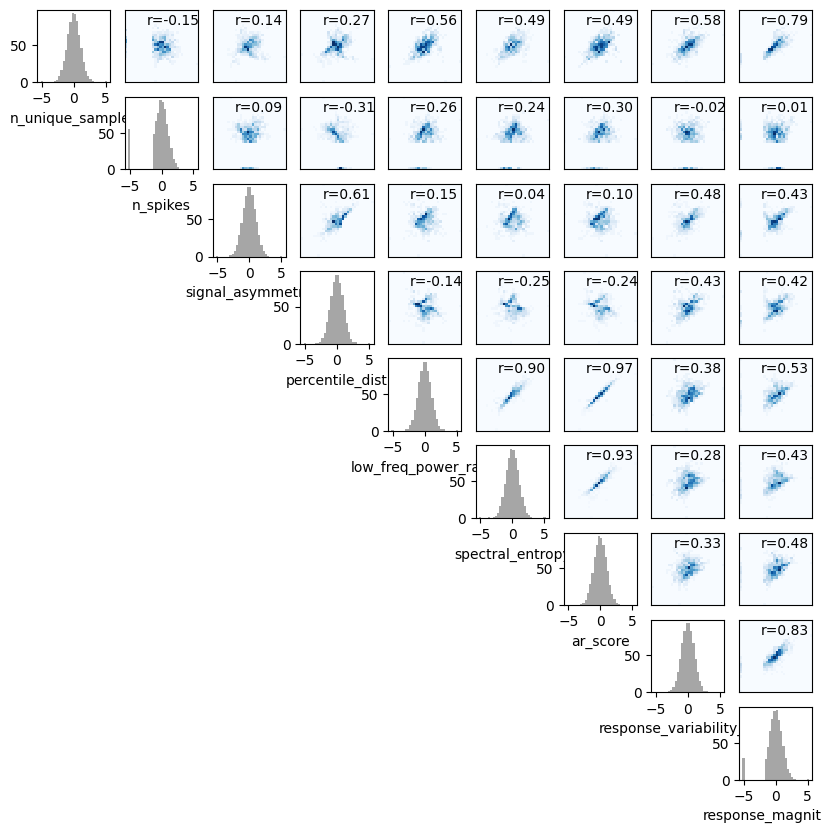

,n_unique_samples,n_spikes,signal_asymmetry,percentile_dist,low_freq_power_ratio,spectral_entropy,ar_score,response_variability_ratio,response_magnitude
n_unique_samples,1.000000,-0.154467,0.138944,0.269289,0.556194,0.492490,0.489630,0.583728,0.794997
n_spikes,-0.154467,1.000000,0.088316,-0.311249,0.258841,0.238464,0.304242,-0.021240,0.009376
signal_asymmetry,0.138944,0.088316,1.000000,0.612764,0.150337,0.035894,0.098678,0.476866,0.431781
percentile_dist,0.269289,-0.311249,0.612764,1.000000,-0.143797,-0.250659,-0.239635,0.431901,0.415428
low_freq_power_ratio,0.556194,0.258841,0.150337,-0.143797,1.000000,0.902190,0.966302,0.384851,0.530546
spectral_entropy,0.492490,0.238464,0.035894,-0.250659,0.902190,1.000000,0.929756,0.283641,0.430927
ar_score,0.489630,0.304242,0.098678,-0.239635,0.966302,0.929756,1.000000,0.325709,0.475713
response_variability_ratio,0.583728,-0.021240,0.476866,0.431901,0.384851,0.283641,0.325709,1.000000,0.825666
response_magnitude,0.794997,0.009376,0.431781,0.415428,0.530546,0.430927,0.475713,0.825666,1.000000


In [364]:
from copulas.multivariate import GaussianMultivariate 

In [366]:
cop = GaussianMultivariate()

In [369]:
cop.fit(df_metrics[metrics_dict.keys()].dropna().values)

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6720: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWa

In [378]:
cop.sample?

Signature: cop.sample(num_rows=1, conditions=None)
Docstring:
Sample values from this model.

Argument:
    num_rows (int):
        Number of rows to sample.
    conditions (dict or pd.Series):
        Mapping of the column names and column values to condition on.

Returns:
    numpy.ndarray:
        Array of shape (n_samples, *) with values randomly
        sampled from this model distribution. If conditions have been
        given, the output array also contains the corresponding columns
        populated with the given values.

Raises:
    NotFittedError:
        if the model is not fitted.
File:      ~/miniconda3/envs/iblenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py
Type:      method

In [550]:
df_metrics['target'] = df_metrics['targeted_regions'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [551]:
df_metrics['target'].unique()

array(['DR', 'MR', 'VTA', 'SNc', 'LC', nan, 'NBM'], dtype=object)

In [401]:
df_metrics = df_metrics.sort_values(['subject', 'date'])

In [402]:
# Convert date column to datetime and compute 'recording_day'
df_metrics['date'] = pd.to_datetime(df_metrics['date'])  # Ensure 'date' column is datetime

def _get_recording_days(group):
    group = group.copy()  # avoid SettingWithCopyWarning
    # group['recording_day'] = (group['date'] - group['date'].iloc[0])
    group['recording_day'] = np.arange(len(group))
    return group

df_metrics = df_metrics.groupby('subject', group_keys=False).apply(_get_recording_days)
# df_metrics['recording_day'] = df_metrics['recording_day'].apply(lambda x: x.days)

/tmp/ipykernel_51833/315210523.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df_metrics.groupby('subject', group_keys=False).apply(_get_recording_days)


In [403]:
# Max days to look into the future
day_max = 21

# Initialize lists to hold results
index = []
data = {'rsquared': [], 'pvalue': [], 'slope': []}

# Loop over metrics
for metric in metrics_dict.keys():
    # Loop over days offset
    for day in range(1, day_max):
        # Filter the data to get values at day 0 and day
        df_day0 = df_metrics[df_metrics['recording_day'] == 0]
        df_day = df_metrics[df_metrics['recording_day'] == day]
        # Merge the data, ensuring paired samples for each subject
        merged = pd.merge(df_day0[['subject', metric]], df_day[['subject', metric]], on='subject', suffixes=('_0', f'_{day}'))
        # Linear regression
        if len(merged) < 3:
            continue
        res = stats.linregress(merged[f'{metric}_0'], merged[f'{metric}_{day}'])
        # Append results
        index.append((metric, day))
        data['rsquared'].append(res.rvalue ** 2)
        data['pvalue'].append(res.pvalue)
        data['slope'].append(res.slope)

# Create the DataFrame
multi_index = pd.MultiIndex.from_tuples(index, names=["metric", "day"])
df_pred = pd.DataFrame(data, index=multi_index)

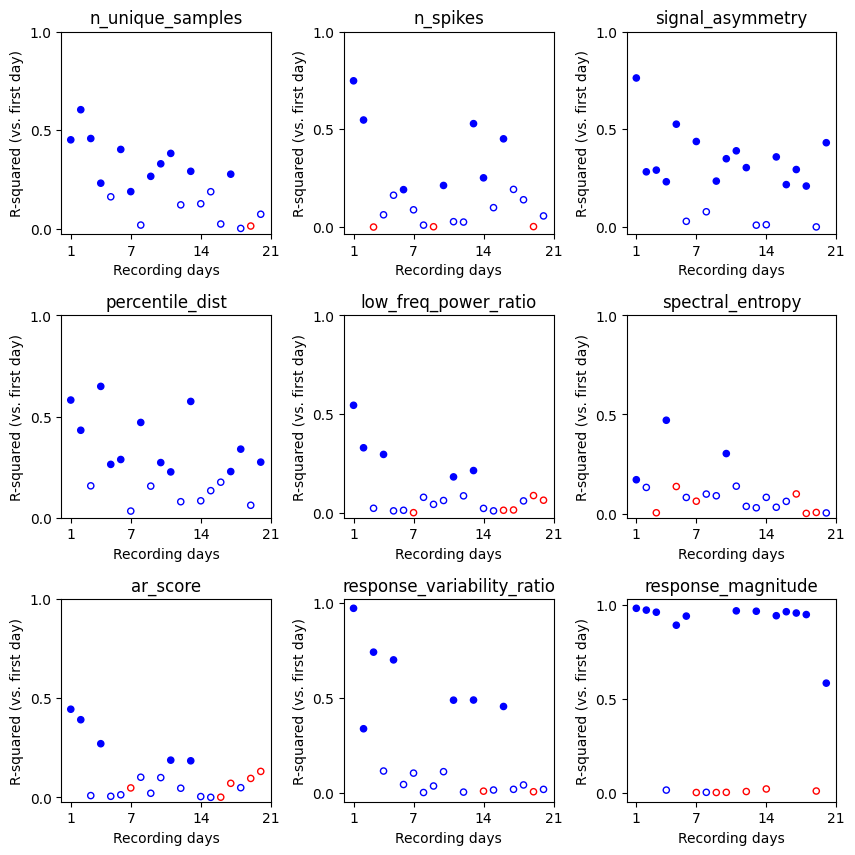

In [404]:
n_metrics = len(metrics_dict.keys())
fig, axs = plt.subplots(int(np.ceil(n_metrics / 3)), 3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.35)

for ax, (metric, values) in zip(axs.ravel(), df_pred.groupby('metric', sort=False)):
    values = values.droplevel('metric').reset_index('day')
    ec = ['blue' if s > 0 else 'red' for s in values['slope']]
    fc = [c if p <= 0.05 else 'none' for c, p in zip(ec, values['pvalue'])]
    ax.scatter(values['day'], values['rsquared'], s=20, ec=ec, fc=fc)
    ax.set_title(metric)
    ax.set_xticks([1, 7, 14, 21])
    ax.set_xlabel('Recording days')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel('R-squared (vs. first day)')